In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor

import os

In [105]:
df = pd.read_csv('../data/processed/preprocessed_data.csv')

In [106]:
df.head(5)

,Entity,Year,Daily Average Temp,Monthly Average Temp,Month
0,Afghanistan,1940,-2.032494,11.327695,1
1,Afghanistan,1940,-0.733503,11.327695,2
2,Afghanistan,1940,1.999134,11.327695,3
3,Afghanistan,1940,10.199754,11.327695,4
4,Afghanistan,1940,17.942135,11.327695,5


In [ ]:
X = df.drop('Daily Average Temp', axis=1)
y = df['Daily Average Temp']
# split data chronologically so that we train on older data and test with newer data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
X_train.head()

,Entity,Year,Monthly Average Temp,Month
6014,Angola,2016,22.886465,3
71221,Georgia,2010,10.112088,2
120599,Montenegro,1959,8.623334,12
15706,Bangladesh,1973,25.110266,11
119862,Mongolia,1983,0.719259,7


In [71]:
X_test.head()

,Entity,Year,Monthly Average Temp,Month
50398,Denmark,1974,8.713705,11
115782,Mauritania,1983,27.948732,7
112125,Madagascar,2018,22.812632,10
56427,El Salvador,1967,25.615232,4
97929,Kenya,1940,23.996480,10


# Scale and Encode

In [72]:
categorical_cols = ["Entity"]
numerical_cols = ["Monthly Average Temp"]
#date_cols = ["Day"]

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])

preprocessor_with_date = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols),
    ("ordinal", OrdinalEncoder(), date_cols)
])

# Linear Regression

## Linear Regression: Training

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [79]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)
linear_regression_y_pred = pipeline.predict(X_test)
joblib.dump(pipeline, '../models/global/linear_regression_global_pipeline.pkl')

['../models/global/linear_regression_global_pipeline.pkl']

## Linear Regression: Evaluation

In [75]:
# Mean Squared Error
mse = mean_squared_error(y_test, linear_regression_y_pred)
print(f"Mean Squared Error: {mse}")

rmse = root_mean_squared_error(y_test, linear_regression_y_pred)

# R-squared
r2 = r2_score(y_test, linear_regression_y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 28.85676379780414
R-squared: 0.7270881906378455


## Linear Regression: Hypertuning

In [ ]:
from sklearn.model_selection import GridSearchCV

def hypertune_model(model_or_pipeline, param_grid, X_train, y_train, cv=5, scoring=None, verbose=1):
    grid_search = GridSearchCV(
        estimator=model_or_pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=verbose,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search

In [ ]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False],
}

best_model, best_params, grid = hypertune_model(
    pipeline, param_grid, X_train, y_train, scoring='neg_mean_squared_error'
)

NameError: name 'preprocessor' is not defined

In [ ]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 3.7132
MSE: 28.8568
RMSE: 5.3718
R²: 0.7271


Text(0.5, 1.0, 'Actual vs Predicted Temperature')

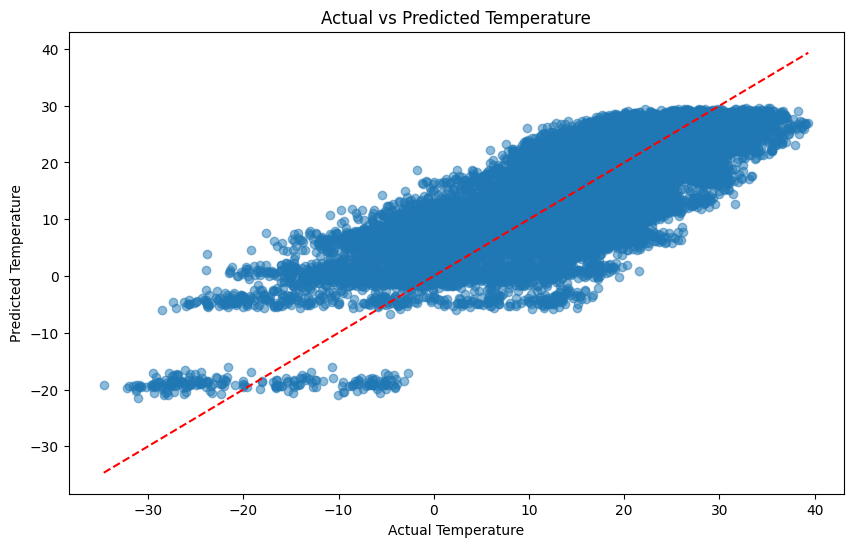

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature')

# Long short-term memory LSTM

In [ ]:
import numpy as np
from LSTM_pipeline import LSTMPipeline

In [ ]:
# focus on one country, and sort by Day
df_country = df[df["Entity"] == "Afghanistan"].copy()
df_country["Day"] = pd.to_datetime(df_country["Day"])
df_country = df_country.sort_values(by="Day")
monthly_temp = df_country[["Monthly Average Temp"]].values

/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0861 - val_loss: 0.0128
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - val_loss: 0.0198
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0113
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_l

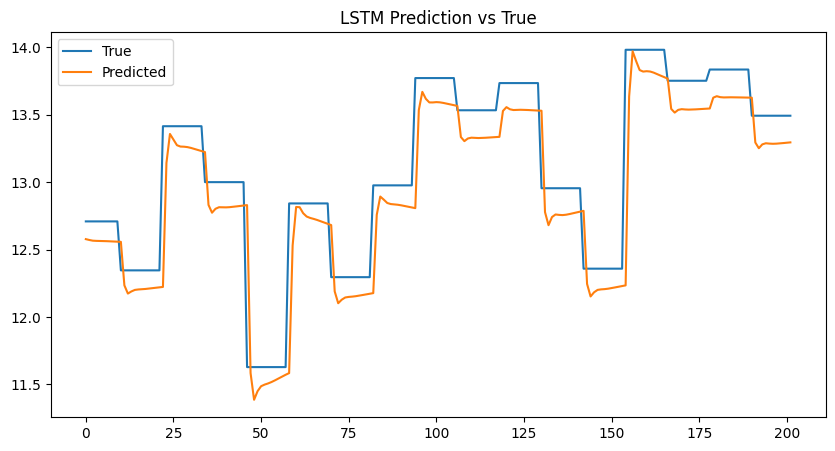

In [ ]:
pipeline = LSTMPipeline(seq_len=12)
pipeline.fit(monthly_temp)
pipeline.plot_results()

In [ ]:
def run_LSTM(countries, countries_to_plot=[], model_dir="models", scaler_dir="scalers"):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(scaler_dir, exist_ok=True)

    results = []

    for country in countries:
        country_df = df[df["Entity"] == country].copy()
        country_df["Day"] = pd.to_datetime(country_df["Day"])
        country_df = country_df.sort_values(by="Day")

        temps = country_df["Monthly Average Temp"].values
        pipeline = LSTMPipeline(seq_len=12)
        
        try:
            pipeline.fit(temps)
            pipeline.save(
                model_path=f"{model_dir}/{country}.keras",
                scaler_path=f"{scaler_dir}/{country}_scaler.pkl"
            )
            metrics = pipeline.evaluate()
            results.append({
                "Country": country,
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2": metrics["R2"]
            })
            print(f"Finished: {country} | MAE: {metrics['MAE']:.2f} | RMSE: {metrics['RMSE']:.2f} | R²: {metrics['R2']:.2f}")

            if country in countries_to_plot:
                pipeline.plot_results()
                
        except Exception as e:
            print(f"Error with {country}: {e}")
    return pd.DataFrame(results)

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0677 - val_loss: 0.0150
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0122
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0111
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0152
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0134
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0067
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0080

Finished: Afghanistan | MAE: 0.13 | RMSE: 0.24 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0492 - val_loss: 0.0065
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0034

Finished: Albania | MAE: 0.17 | RMSE: 0.20 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0358 - val_loss: 0.0016
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 8.5910e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 5.8448e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 5.6047e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 6.2892e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 9.4374e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 9.7370e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Finished: Algeria | MAE: 0.13 | RMSE: 0.21 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0380 - val_loss: 0.0142
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0190
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0066
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0093
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0073
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0070

Finished: American Samoa | MAE: 0.06 | RMSE: 0.09 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0397 - val_loss: 0.0101
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0045

Finished: Andorra | MAE: 0.09 | RMSE: 0.28 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0488 - val_loss: 0.0075
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.003

Finished: Angola | MAE: 0.20 | RMSE: 0.22 | R²: 0.63
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0283 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0

Finished: Anguilla | MAE: 0.07 | RMSE: 0.10 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0303 - val_loss: 0.0053
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0090
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0024

Finished: Antigua and Barbuda | MAE: 0.05 | RMSE: 0.10 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0681 - val_loss: 0.0156
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0149
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0129
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0091
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0093
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0085


Finished: Argentina | MAE: 0.04 | RMSE: 0.12 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0672 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0035
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0041
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0021

Finished: Armenia | MAE: 0.14 | RMSE: 0.31 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0441 - val_loss: 0.0110
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0056

Finished: Australia | MAE: 0.09 | RMSE: 0.15 | R²: 0.89


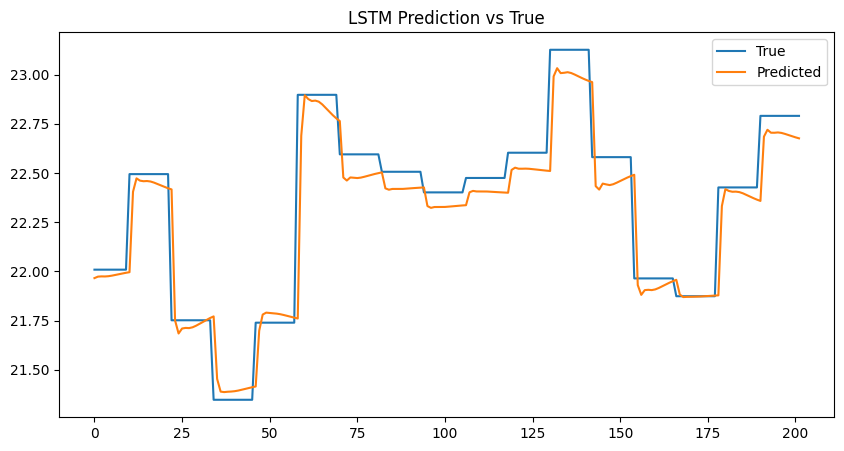

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1344 - val_loss: 0.0273
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0122
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0097
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0041


Finished: Austria | MAE: 0.15 | RMSE: 0.24 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0614 - val_loss: 0.0087
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - val_loss: 0.0084
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0070
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0050
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0017

Finished: Azerbaijan | MAE: 0.14 | RMSE: 0.26 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0526 - val_loss: 0.0077
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.003

Finished: Bahamas | MAE: 0.06 | RMSE: 0.09 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1048 - val_loss: 0.0077
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0095
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0051
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0071
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.002

Finished: Bahrain | MAE: 0.04 | RMSE: 0.13 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0816 - val_loss: 0.0053
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0066
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0046
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0060 - val_loss: 0.00

Finished: Bangladesh | MAE: 0.09 | RMSE: 0.12 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1363 - val_loss: 0.0106
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0082
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0041
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0026
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0031


Finished: Belarus | MAE: 0.14 | RMSE: 0.24 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0499 - val_loss: 0.0036
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0100
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0025

Finished: Belgium | MAE: 0.08 | RMSE: 0.27 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0334 - val_loss: 0.0040
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0016

Finished: Belize | MAE: 0.05 | RMSE: 0.10 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0957 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 9.6195e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 7.8477e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss

Finished: Benin | MAE: 0.10 | RMSE: 0.13 | R²: 0.76
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0522 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 9.3075e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.

Finished: Bhutan | MAE: 0.11 | RMSE: 0.14 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0460 - val_loss: 0.0031
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.003

Finished: Bolivia | MAE: 0.18 | RMSE: 0.21 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0707 - val_loss: 0.0042
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0018

Finished: Bosnia and Herzegovina | MAE: 0.16 | RMSE: 0.20 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0723 - val_loss: 0.0258
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0242
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0188
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0237
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0175
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0135
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0134
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0143
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0121
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0114
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0118

Finished: Botswana | MAE: 0.24 | RMSE: 0.32 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0581 - val_loss: 0.0089
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0071
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0090
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0041

Finished: Brazil | MAE: 0.11 | RMSE: 0.14 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0762 - val_loss: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 5.7266e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 4.6790e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 4.1087e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 4.8710e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 3.9084e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 3.4097e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 7.1897e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

Finished: Brunei | MAE: 0.08 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0730 - val_loss: 0.0075
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0044

Finished: Bulgaria | MAE: 0.23 | RMSE: 0.26 | R²: 0.76
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0759 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0015
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0011
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0010

Finished: Burkina Faso | MAE: 0.19 | RMSE: 0.21 | R²: 0.35
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0295 - val_loss: 0.0051
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023

Finished: Burundi | MAE: 0.10 | RMSE: 0.13 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0478 - val_loss: 0.0024
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 9.0110e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 9.

Finished: Cambodia | MAE: 0.07 | RMSE: 0.15 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0332 - val_loss: 0.0067
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 9.7164e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 8.3695e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss

Finished: Cameroon | MAE: 0.11 | RMSE: 0.13 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0365 - val_loss: 0.0140
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0127
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0129
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0099
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0079
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0087
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0077
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0060

Finished: Canada | MAE: 0.22 | RMSE: 0.34 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0455 - val_loss: 0.0076
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0032

Finished: Cape Verde | MAE: 0.07 | RMSE: 0.16 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0727 - val_loss: 0.0068
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0015

Finished: Cayman Islands | MAE: 0.09 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0251 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0027
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0018

Finished: Central African Republic | MAE: 0.12 | RMSE: 0.15 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0582 - val_loss: 0.0026
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0059

Finished: Chad | MAE: 0.30 | RMSE: 0.33 | R²: 0.11
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0556 - val_loss: 0.0147
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0142
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - val_loss: 0.0136
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0124
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0107
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0084
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0101
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0079

Finished: Chile | MAE: 0.05 | RMSE: 0.10 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0390 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0066
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0110
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024

Finished: China | MAE: 0.10 | RMSE: 0.12 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0881 - val_loss: 0.0044
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 6.2963e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 9.

Finished: Colombia | MAE: 0.06 | RMSE: 0.11 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0566 - val_loss: 0.0124
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0068
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0127
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0046
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0032

Finished: Comoros | MAE: 0.05 | RMSE: 0.09 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0238 - val_loss: 0.0107
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0110
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0029

Finished: Congo | MAE: 0.06 | RMSE: 0.09 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0879 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0079
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0089
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0012

Finished: Cook Islands | MAE: 0.07 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0965 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0093 - val_loss: 0.0020
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0026
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 0.

Finished: Costa Rica | MAE: 0.14 | RMSE: 0.16 | R²: 0.65
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0790 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.002

Finished: Cote d'Ivoire | MAE: 0.08 | RMSE: 0.10 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0739 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0030

Finished: Croatia | MAE: 0.31 | RMSE: 0.34 | R²: 0.65
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0871 - val_loss: 0.0115
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - val_loss: 0.0096
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0037
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0024

Finished: Cuba | MAE: 0.10 | RMSE: 0.13 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0632 - val_loss: 0.0063
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0029
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0012

Finished: Cyprus | MAE: 0.05 | RMSE: 0.16 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0568 - val_loss: 0.0035
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025

Finished: Czechia | MAE: 0.14 | RMSE: 0.26 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0291 - val_loss: 0.0068
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0021

Finished: Democratic Republic of Congo | MAE: 0.12 | RMSE: 0.14 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0583 - val_loss: 0.0060
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0062
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - val_loss: 0.0067
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0049
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0029

Finished: Denmark | MAE: 0.15 | RMSE: 0.28 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0819 - val_loss: 6.5892e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 9.6823e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 8.4226e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 8.2269e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 5.8815e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 5.7516e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 6.2276e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 8.7858e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 7.3665e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 4.8840e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Finished: Djibouti | MAE: 0.05 | RMSE: 0.11 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0503 - val_loss: 0.0128
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0088
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.001

Finished: Dominican Republic | MAE: 0.05 | RMSE: 0.09 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0604 - val_loss: 0.0124
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0097
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0047

Finished: East Timor | MAE: 0.12 | RMSE: 0.16 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0492 - val_loss: 0.0020
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0035
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0016

Finished: Ecuador | MAE: 0.08 | RMSE: 0.12 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0621 - val_loss: 0.0064
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0109
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 6.0962e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 8.9870e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - va

Finished: Egypt | MAE: 0.17 | RMSE: 0.26 | R²: 0.69
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0373 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - val_loss: 0.001

Finished: El Salvador | MAE: 0.17 | RMSE: 0.21 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0203 - val_loss: 0.0024
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 9.4969e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 8.8001e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 4.6525e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 6.5781e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 6.8994e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.001

Finished: Equatorial Guinea | MAE: 0.07 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0645 - val_loss: 8.7937e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 9.0552e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 8.3364e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 6.9016e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 8.1128e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 5.8232e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 5.3927e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 9.7241e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 8.1499e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

Finished: Eritrea | MAE: 0.06 | RMSE: 0.13 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0724 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - val_loss: 0.0057
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - val_loss: 0.0012
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - val_loss: 0.0010
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - val_loss: 7.6458e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - val_loss:

Finished: Estonia | MAE: 0.26 | RMSE: 0.36 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1046 - val_loss: 0.0084
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - val_loss: 0.0089
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0089
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - val_loss: 0.0079
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0052
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0064
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.004

Finished: Eswatini | MAE: 0.09 | RMSE: 0.15 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1080 - val_loss: 0.0029
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 8.9432e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 9.

Finished: Ethiopia | MAE: 0.06 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0912 - val_loss: 0.0251
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0251
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0217
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0189
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0157
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0142
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0177
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0131
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0119
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0120

Finished: Falkland Islands | MAE: 0.08 | RMSE: 0.13 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1042 - val_loss: 0.0200
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0265
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0145
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0195
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0123
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0162
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0102
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0153
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0121
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0112

Finished: Faroe Islands | MAE: 0.12 | RMSE: 0.17 | R²: 0.69
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0362 - val_loss: 0.0099
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0115
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0115
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0078
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0074
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0097
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0051

Finished: Fiji | MAE: 0.08 | RMSE: 0.12 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0512 - val_loss: 0.0020
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - val_loss: 0.0020
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0057
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0023
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0054
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 9.6698e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0010
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.

Finished: Finland | MAE: 0.22 | RMSE: 0.37 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0418 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.005

Finished: France | MAE: 0.08 | RMSE: 0.22 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0576 - val_loss: 0.0123
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0114
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0040

Finished: French Polynesia | MAE: 0.03 | RMSE: 0.10 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0228 - val_loss: 0.0068
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0027

Finished: Gabon | MAE: 0.07 | RMSE: 0.09 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0821 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0057
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0029

Finished: Gambia | MAE: 0.05 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0625 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0026
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0030
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 8.2289e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 7.6180e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss

Finished: Georgia | MAE: 0.41 | RMSE: 0.48 | R²: 0.46
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0975 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - val_loss: 0.0044
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0

Finished: Germany | MAE: 0.26 | RMSE: 0.35 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0641 - val_loss: 0.0044
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 2.3513e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 6.8357e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0071
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 9.9577e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 3.7859e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - 

Finished: Ghana | MAE: 0.13 | RMSE: 0.15 | R²: 0.69
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0453 - val_loss: 0.0052
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0017

Finished: Greece | MAE: 0.12 | RMSE: 0.18 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0514 - val_loss: 0.0087
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0089
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0027

Finished: Greenland | MAE: 0.23 | RMSE: 0.48 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0357 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0036

Finished: Guatemala | MAE: 0.09 | RMSE: 0.13 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0760 - val_loss: 0.0036
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0028
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 6.9783e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 6.0889e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 5.2247e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_

Finished: Guinea | MAE: 0.07 | RMSE: 0.10 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0912 - val_loss: 0.0031
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0012

Finished: Guinea-Bissau | MAE: 0.05 | RMSE: 0.10 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0609 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0012

Finished: Guyana | MAE: 0.04 | RMSE: 0.10 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0386 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0030

Finished: Haiti | MAE: 0.07 | RMSE: 0.10 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0816 - val_loss: 0.0056
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.003

Finished: Heard Island and McDonald Islands | MAE: 0.04 | RMSE: 0.09 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0556 - val_loss: 0.0017
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0010

Finished: Honduras | MAE: 0.14 | RMSE: 0.18 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0395 - val_loss: 0.0083
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0040
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0093
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0039

Finished: Hong Kong | MAE: 0.07 | RMSE: 0.12 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0959 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0033

Finished: Hungary | MAE: 0.30 | RMSE: 0.34 | R²: 0.68
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0747 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0046

Finished: Iceland | MAE: 0.14 | RMSE: 0.22 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1187 - val_loss: 0.0039
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0024

Finished: India | MAE: 0.08 | RMSE: 0.11 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0238 - val_loss: 0.0011
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 7.8828e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 4.3878e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 3.9769e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 2.7242e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 2.4245e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 2.6056e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 3.3105e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

Finished: Indonesia | MAE: 0.07 | RMSE: 0.09 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0539 - val_loss: 0.0047
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0028
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0102
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0013

Finished: Iran | MAE: 0.18 | RMSE: 0.24 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0816 - val_loss: 0.0082
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - val_loss: 0.0061
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 4.6420e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 9.2526e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss

Finished: Iraq | MAE: 0.17 | RMSE: 0.27 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1746 - val_loss: 0.0111
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - val_loss: 0.0099
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - val_loss: 0.0068
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0058

Finished: Ireland | MAE: 0.07 | RMSE: 0.15 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0447 - val_loss: 0.0067
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0084
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0025

Finished: Isle of Man | MAE: 0.05 | RMSE: 0.16 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0315 - val_loss: 0.0028
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 7.2140e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 6.1021e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss

Finished: Israel | MAE: 0.19 | RMSE: 0.27 | R²: 0.70
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0608 - val_loss: 0.0057
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0077
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020

Finished: Italy | MAE: 0.10 | RMSE: 0.15 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0311 - val_loss: 0.0031
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0013

Finished: Jamaica | MAE: 0.05 | RMSE: 0.08 | R²: 0.96
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0650 - val_loss: 0.0061
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0031

Finished: Japan | MAE: 0.15 | RMSE: 0.18 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0552 - val_loss: 0.0056
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 7.2360e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 5.0573e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss

Finished: Jordan | MAE: 0.14 | RMSE: 0.27 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1518 - val_loss: 0.0251
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - val_loss: 0.0137
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0129
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0126
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0049

Finished: Kazakhstan | MAE: 0.24 | RMSE: 0.33 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1155 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 9.3414e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 9.0156e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 9.7196e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_

Finished: Kenya | MAE: 0.11 | RMSE: 0.15 | R²: 0.64
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0825 - val_loss: 0.0139
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0167 - val_loss: 0.0124
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0162
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0068

Finished: Kiribati | MAE: 0.07 | RMSE: 0.16 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0927 - val_loss: 0.0091
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0032

Finished: Kosovo | MAE: 0.08 | RMSE: 0.14 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0385 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 4.2224e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 8.9271e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 6.6220e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_

Finished: Kuwait | MAE: 0.07 | RMSE: 0.19 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0715 - val_loss: 0.0117
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 - val_loss: 0.0138
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0087
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0114
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0152
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0052

Finished: Kyrgyzstan | MAE: 0.13 | RMSE: 0.20 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0690 - val_loss: 0.0082
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0030

Finished: Laos | MAE: 0.07 | RMSE: 0.17 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0410 - val_loss: 0.0027
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 7.6649

Finished: Latvia | MAE: 0.11 | RMSE: 0.26 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0374 - val_loss: 0.0020
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - val_loss: 0.0014
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0015
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0050
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 9.1373e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.

Finished: Lebanon | MAE: 0.28 | RMSE: 0.35 | R²: 0.65
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0494 - val_loss: 0.0102
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0032

Finished: Lesotho | MAE: 0.13 | RMSE: 0.22 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0313 - val_loss: 3.8518e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 4.3973e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 3.3653e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 2.9235e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 6.4144e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 2.6463e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 7.9117e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 3.6410e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 3.1656e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 7.7867e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 3.2332e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0

Finished: Liberia | MAE: 0.05 | RMSE: 0.08 | R²: 0.95
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0676 - val_loss: 0.0023
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0014
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 4.3174e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0074
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 5.3525e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 2.7521e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 7.5047e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - 

Finished: Libya | MAE: 0.12 | RMSE: 0.29 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0673 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0032
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0017

Finished: Lithuania | MAE: 0.20 | RMSE: 0.28 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0959 - val_loss: 0.0074
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - val_loss: 0.0087
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0038
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0132
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0042

Finished: Luxembourg | MAE: 0.18 | RMSE: 0.30 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0541 - val_loss: 0.0047
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 6.8848e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 6.5568e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 7.0557e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 9.3499e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - 

Finished: Madagascar | MAE: 0.05 | RMSE: 0.09 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0652 - val_loss: 0.0117
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0114
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0057

Finished: Malawi | MAE: 0.04 | RMSE: 0.08 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0400 - val_loss: 0.0013
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 8.1299e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 7.

Finished: Malaysia | MAE: 0.07 | RMSE: 0.11 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0571 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 8.2118e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 7.9260e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss

Finished: Mali | MAE: 0.12 | RMSE: 0.18 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1133 - val_loss: 0.0102
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0040
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0026
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0012

Finished: Mauritania | MAE: 0.16 | RMSE: 0.22 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0800 - val_loss: 0.0134
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0088
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0034

Finished: Mauritius | MAE: 0.03 | RMSE: 0.10 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0398 - val_loss: 0.0039
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019


Finished: Mexico | MAE: 0.06 | RMSE: 0.13 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0812 - val_loss: 0.0150
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_loss: 0.0100
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0085
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0059


Finished: Moldova | MAE: 0.15 | RMSE: 0.25 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0842 - val_loss: 0.0263
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0263
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0186
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0207
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0138
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0141
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0147
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0101
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0116
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0090

Finished: Mongolia | MAE: 0.12 | RMSE: 0.20 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0531 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0088
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0035

Finished: Montenegro | MAE: 0.08 | RMSE: 0.13 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0591 - val_loss: 0.0020
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0027
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 8.3634e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.

Finished: Morocco | MAE: 0.15 | RMSE: 0.21 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0604 - val_loss: 0.0099
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0091
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0082
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0034

Finished: Mozambique | MAE: 0.05 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0885 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0024

Finished: Myanmar | MAE: 0.10 | RMSE: 0.14 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0428 - val_loss: 0.0131
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0105
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0085
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0098
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0073
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0059

Finished: Namibia | MAE: 0.14 | RMSE: 0.24 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0783 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.00

Finished: Nepal | MAE: 0.10 | RMSE: 0.14 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0722 - val_loss: 0.0057
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0128 - val_loss: 0.0083
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0107 - val_loss: 0.0041
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0

Finished: Netherlands | MAE: 0.09 | RMSE: 0.26 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0414 - val_loss: 0.0035
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0028
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0019

Finished: New Caledonia | MAE: 0.08 | RMSE: 0.15 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0887 - val_loss: 0.0128
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - val_loss: 0.0125
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0117
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0104
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0095
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0089
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0075
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0064

Finished: New Zealand | MAE: 0.09 | RMSE: 0.15 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0590 - val_loss: 0.0024
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0011

Finished: Nicaragua | MAE: 0.13 | RMSE: 0.16 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1141 - val_loss: 0.0082
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 9.0365e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 9.3167e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss

Finished: Niger | MAE: 0.21 | RMSE: 0.26 | R²: 0.57
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0887 - val_loss: 0.0056
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0017

Finished: Nigeria | MAE: 0.11 | RMSE: 0.14 | R²: 0.69
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0694 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0021

Finished: North Korea | MAE: 0.08 | RMSE: 0.16 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0815 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0024

Finished: North Macedonia | MAE: 0.21 | RMSE: 0.23 | R²: 0.67
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0944 - val_loss: 0.0042
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0040
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0169
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.002

Finished: Norway | MAE: 0.10 | RMSE: 0.29 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0565 - val_loss: 0.0030
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0029

Finished: Oman | MAE: 0.07 | RMSE: 0.12 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1125 - val_loss: 0.0385
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - val_loss: 0.0358
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - val_loss: 0.0221
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0270
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0220
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0158
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0305
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0156
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0142
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0136
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0131
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0134

Finished: Pakistan | MAE: 0.05 | RMSE: 0.13 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0479 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0038
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0096

Finished: Palestine | MAE: 0.16 | RMSE: 0.24 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0897 - val_loss: 0.0097
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0044
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0027

Finished: Panama | MAE: 0.11 | RMSE: 0.14 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0517 - val_loss: 6.2350e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 6.1245e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 5.3860e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 8.8613e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 8.4773e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 6.6708e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 5.9713e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

Finished: Papua New Guinea | MAE: 0.08 | RMSE: 0.11 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0784 - val_loss: 0.0088
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - val_loss: 0.0070
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - val_loss: 0.0075
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0056

Finished: Paraguay | MAE: 0.26 | RMSE: 0.31 | R²: 0.71
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0372 - val_loss: 8.2842e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 9.3268e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 6.2967e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 6.5243e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 8.8762e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 4.6571e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 4.4369e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

Finished: Peru | MAE: 0.06 | RMSE: 0.11 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0925 - val_loss: 4.3416e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 4.7674e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 6.8555e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 4.3542e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 4.9244e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 8.6862e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 3.8936e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 3.5489e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Finished: Philippines | MAE: 0.09 | RMSE: 0.11 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1113 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0079
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0026

Finished: Poland | MAE: 0.28 | RMSE: 0.34 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0848 - val_loss: 0.0035
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0112 - val_loss: 0.0041
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - val_loss: 0.0026
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - val_loss: 0.00

Finished: Portugal | MAE: 0.15 | RMSE: 0.20 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0415 - val_loss: 0.0034
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0018

Finished: Puerto Rico | MAE: 0.12 | RMSE: 0.15 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0360 - val_loss: 0.0071
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 8.9687

Finished: Qatar | MAE: 0.05 | RMSE: 0.13 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0605 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0075
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0038

Finished: Romania | MAE: 0.21 | RMSE: 0.25 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0554 - val_loss: 0.0167
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - val_loss: 0.0187
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - val_loss: 0.0153
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0160
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0135
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0071
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0104
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0054

Finished: Russia | MAE: 0.18 | RMSE: 0.28 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0333 - val_loss: 0.0044
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0013

Finished: Rwanda | MAE: 0.06 | RMSE: 0.12 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0791 - val_loss: 0.0142
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0129
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0109
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0104
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0073

Finished: Saint Helena | MAE: 0.04 | RMSE: 0.08 | R²: 0.89


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0340 - val_loss: 0.0079
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_l

Finished: Saint Vincent and the Grenadines | MAE: 0.08 | RMSE: 0.11 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0523 - val_loss: 0.0133
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0168
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0080
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0095
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0083
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0075
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0081
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0047

Finished: Samoa | MAE: 0.05 | RMSE: 0.09 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0257 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.001

Finished: Sao Tome and Principe | MAE: 0.04 | RMSE: 0.08 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0526 - val_loss: 8.0470e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 5.0616e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 5.0305e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 7.3906e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 3.2628e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

Finished: Saudi Arabia | MAE: 0.06 | RMSE: 0.14 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1372 - val_loss: 0.0042
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0018
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0013
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0014
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0012

Finished: Senegal | MAE: 0.05 | RMSE: 0.11 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0611 - val_loss: 0.0052
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0029

Finished: Serbia | MAE: 0.25 | RMSE: 0.28 | R²: 0.71
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0434 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0038

Finished: Seychelles | MAE: 0.05 | RMSE: 0.08 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0217 - val_loss: 8.8727e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 6.0879e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 8.3652e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 5.2007e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 -

Finished: Sierra Leone | MAE: 0.05 | RMSE: 0.09 | R²: 0.95
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0570 - val_loss: 0.0040
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0088
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0016

Finished: Slovakia | MAE: 0.18 | RMSE: 0.26 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1125 - val_loss: 0.0122
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0029

Finished: Slovenia | MAE: 0.28 | RMSE: 0.32 | R²: 0.64
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0268 - val_loss: 0.0032
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0016

Finished: Solomon Islands | MAE: 0.09 | RMSE: 0.10 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0463 - val_loss: 0.0040
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0012

Finished: Somalia | MAE: 0.06 | RMSE: 0.10 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0335 - val_loss: 0.0051
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.003

Finished: South Africa | MAE: 0.05 | RMSE: 0.15 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0930 - val_loss: 0.0131
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0059

Finished: South Georgia and the South Sandwich Islands | MAE: 0.07 | RMSE: 0.16 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0491 - val_loss: 0.0046
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0102
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0029

Finished: South Korea | MAE: 0.09 | RMSE: 0.14 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0597 - val_loss: 0.0055
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0016

Finished: South Sudan | MAE: 0.18 | RMSE: 0.22 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0490 - val_loss: 0.0074
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0

Finished: Spain | MAE: 0.13 | RMSE: 0.21 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1326 - val_loss: 0.0078
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0016
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0013
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 9.8067e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 7.5222e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss

Finished: Sri Lanka | MAE: 0.13 | RMSE: 0.15 | R²: 0.63
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0747 - val_loss: 0.0044
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - val_loss: 5.9098e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 7.1431e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 8.8839e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_

Finished: Sudan | MAE: 0.18 | RMSE: 0.22 | R²: 0.59
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0341 - val_loss: 0.0026
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0018
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 8.9098e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 8.1101e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss

Finished: Suriname | MAE: 0.10 | RMSE: 0.15 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0795 - val_loss: 0.0028
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0026
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0047
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0035
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 8.4554e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 7.

Finished: Sweden | MAE: 0.12 | RMSE: 0.35 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0423 - val_loss: 0.0056
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0045
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0018

Finished: Switzerland | MAE: 0.14 | RMSE: 0.26 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0498 - val_loss: 0.0018
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0032
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0028
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0039
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 5.7962e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 5.3258e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss

Finished: Syria | MAE: 0.23 | RMSE: 0.31 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0734 - val_loss: 0.0099
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170 - val_loss: 0.0082
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0124
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0078
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0051
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0075
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - val_loss: 0.004

Finished: Tajikistan | MAE: 0.16 | RMSE: 0.24 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0625 - val_loss: 0.0138
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - val_loss: 0.0174
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0135
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0110
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.005

Finished: Tanzania | MAE: 0.09 | RMSE: 0.11 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0592 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0016

Finished: Thailand | MAE: 0.09 | RMSE: 0.17 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0490 - val_loss: 0.0012
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 9.2426e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 4.8332e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 4.4212e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 3.0882e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 5.5550e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

Finished: Togo | MAE: 0.07 | RMSE: 0.11 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0340 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0016

Finished: Trinidad and Tobago | MAE: 0.10 | RMSE: 0.13 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0624 - val_loss: 0.0026
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0019
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 8.7052e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 7.6946e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss

Finished: Tunisia | MAE: 0.12 | RMSE: 0.17 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0817 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166 - val_loss: 0.0032
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - val_loss: 0.0013
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0017

Finished: Turkey | MAE: 0.23 | RMSE: 0.33 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0771 - val_loss: 0.0034
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0030
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0016

Finished: Turkmenistan | MAE: 0.12 | RMSE: 0.23 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0505 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019

Finished: Uganda | MAE: 0.05 | RMSE: 0.10 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0548 - val_loss: 0.0125
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0075
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0047

Finished: Ukraine | MAE: 0.10 | RMSE: 0.19 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0620 - val_loss: 0.0216
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0028
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0229
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 8.5627e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 7.2701e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss

Finished: United Arab Emirates | MAE: 0.10 | RMSE: 0.16 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1253 - val_loss: 0.0164
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0121
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0044

Finished: United Kingdom | MAE: 0.10 | RMSE: 0.21 | R²: 0.83


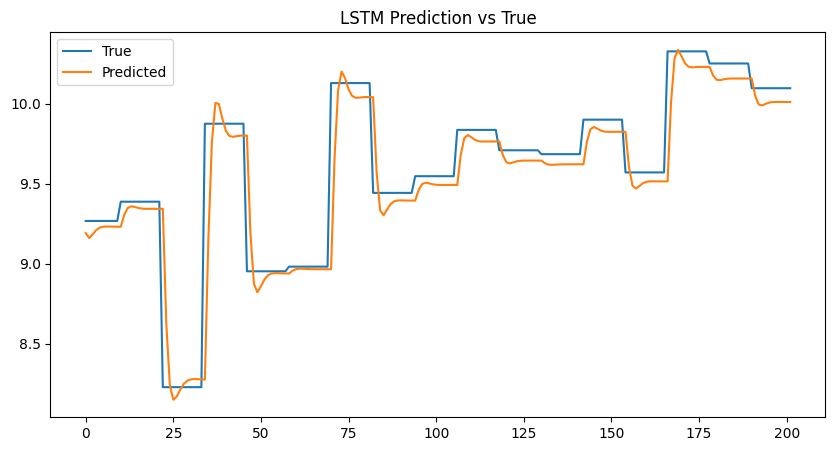

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0289 - val_loss: 0.0047
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0027


Finished: United States | MAE: 0.08 | RMSE: 0.16 | R²: 0.92


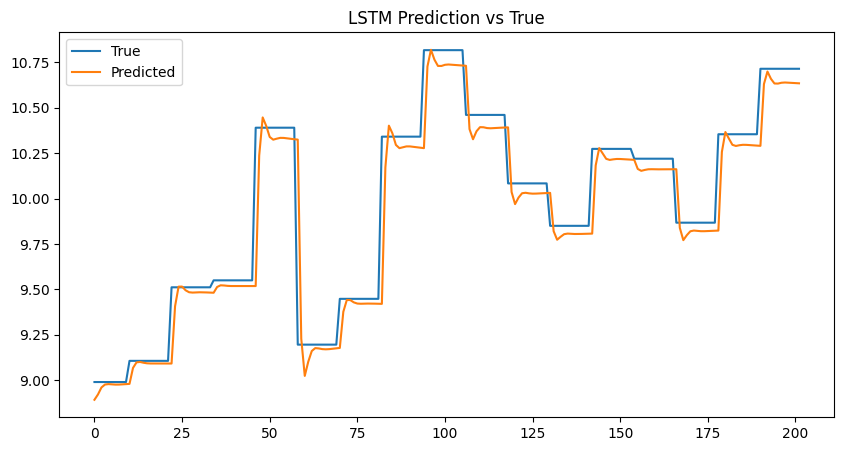

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0259 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0029

Finished: United States Virgin Islands | MAE: 0.09 | RMSE: 0.12 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0660 - val_loss: 0.0117
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0061

Finished: Uruguay | MAE: 0.09 | RMSE: 0.17 | R²: 0.76
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0526 - val_loss: 0.0072
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0093
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0113
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0045
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0034


Finished: Uzbekistan | MAE: 0.27 | RMSE: 0.34 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0616 - val_loss: 0.0083
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0031


Finished: Vanuatu | MAE: 0.05 | RMSE: 0.09 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0703 - val_loss: 0.0026
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 9.3666e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.

Finished: Venezuela | MAE: 0.18 | RMSE: 0.22 | R²: 0.68
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0636 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0018

Finished: Vietnam | MAE: 0.09 | RMSE: 0.17 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0154 - val_loss: 0.0011
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 9.6925e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 8.2197e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 8.9917e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 6.7535e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 5.7625e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 9.1294e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 6.6082e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6056e-04 - val_loss: 7.9438e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9033e-04 - val_loss: 5.2129e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0

Finished: World | MAE: 0.06 | RMSE: 0.07 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0383 - val_loss: 0.0025
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 8.1700e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 7.8787e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 7.9218e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 7.3528e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 6.8514e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 7.9443e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 8.4060e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

Finished: Yemen | MAE: 0.06 | RMSE: 0.12 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0524 - val_loss: 0.0170
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179 - val_loss: 0.0145
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 0.0093
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - val_loss: 0.0074
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - val_loss: 0.

Finished: Zambia | MAE: 0.11 | RMSE: 0.13 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0308 - val_loss: 0.0144
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0109
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.005

Finished: Zimbabwe | MAE: 0.08 | RMSE: 0.16 | R²: 0.89


In [ ]:
countries = df["Entity"].unique()
results = run_LSTM(countries, {"United States", "United Kingdom", "Australia"})


In [ ]:
results

,Country,MAE,RMSE,R2
0,Afghanistan,0.131918,0.238527,0.867284
1,Albania,0.174953,0.199016,0.793006
2,Algeria,0.133811,0.208095,0.857535
3,American Samoa,0.058580,0.094957,0.861911
4,Andorra,0.092880,0.278759,0.864998
...,...,...,...,...
190,Vietnam,0.088229,0.167282,0.856512
191,World,0.057530,0.067534,0.900673
192,Yemen,0.055030,0.122180,0.889659
193,Zambia,0.106504,0.134918,0.847727


In [ ]:
results.to_csv('../metrics/LSTM/LSTM-epochs=30-batch_size=16-validation_split=0.1.csv', index=False)

## LSTM: Hypertuning

In [21]:
import itertools
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop


def hypertune_lstm(raw_data, param_grid, seq_len=12, verbose=False):
    best_score = float('inf')
    best_params = None
    best_model = None
    scores = None

    all_keys = list(param_grid.keys())
    all_combinations = list(itertools.product(*param_grid.values()))

    for combo in all_combinations:
        params = dict(zip(all_keys, combo))
        if verbose:
            print(f"Testing: {params}")

        try:
            # Build pipeline
            pipeline = LSTMPipeline(seq_len=params.get('seq_len', seq_len))

            # Scale and sequence data
            data_scaled = pipeline.scaler.fit_transform(raw_data.reshape(-1, 1))
            X, y = pipeline.create_sequences(data_scaled)
            split = int(len(X) * 0.8)
            X_train, y_train = X[:split], y[:split]
            X_val, y_val = X[split:], y[split:]

            # Reshape to 3D for LSTM
            X_train = X_train.reshape((-1, params['seq_len'], 1))
            X_val = X_val.reshape((-1, params['seq_len'], 1))

            model = Sequential()
            model.add(Input(shape=(params['seq_len'], 1)))

            for i in range(params.get('num_lstm_layers', 1)):
                return_sequences = (i < params['num_lstm_layers'] - 1)  # True for all but last layer
                model.add(LSTM(params['lstm_units'], return_sequences=return_sequences))

            model.add(Dense(1))


            optimizer = {
                'adam': Adam,
                'rmsprop': RMSprop
            }[params['optimizer']](learning_rate=params['learning_rate'])

            model.compile(loss='mse', optimizer=optimizer)

            callbacks = []
            if params.get("use_early_stopping", False):
                callbacks.append(EarlyStopping(patience=params.get("patience", 5), restore_best_weights=True))

            model.fit(
                X_train, y_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=0
            )

            y_pred = model.predict(X_val)
            y_val_inv = pipeline.scaler.inverse_transform(y_val.reshape(-1, 1))
            y_pred_inv = pipeline.scaler.inverse_transform(y_pred)

            mae = mean_absolute_error(y_val_inv, y_pred_inv)
            rmse = root_mean_squared_error(y_val_inv, y_pred_inv)
            mse = mean_squared_error(y_val_inv, y_pred_inv)
            r2 = r2_score(y_val_inv, y_pred_inv)

            if verbose:
                print(f"MAE: {mae:.4f}")

            if mae < best_score:
                best_score = mae
                scores = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MSE' : mse}
                best_params = params
                best_model = model

        except Exception as e:
            print(f"Error with parameters {params}: {e}")

    return best_model, best_params, best_score, scores

In [22]:
def hypertune_all_countries(df, countries, param_grid):
    results = []

    for country in countries:
        print(f"\nHypertuning for {country}...")
        country_df = df[df["Entity"] == country].copy()
        country_df = country_df.sort_values(by="Day")
        temps = country_df["Monthly Average Temp"].values

        try:
            best_model, best_params, best_score, scores = hypertune_lstm(temps, param_grid)
            results.append({
                "Country": country,
                "Best_MAE": best_score,
                "Best_Params": best_params,
                "Scores" : scores
            })
            print(f"Done: {country} | MAE: {scores['MAE']:.4f} | RMSE: {scores['RMSE']:.4f} | R2: {scores['R2']:.4f} | MSE: {scores['MSE']:.4f}")
        except Exception as e:
            print(f"Error with {country}: {e}")
            results.append({
                "Country": country,
                "Best_MAE": None,
                "Best_Params": None,
                "Scores" : None,
                "Error": str(e)
            })

    return pd.DataFrame(results)

In [23]:
param_grid = {
    'seq_len': [12],  # Different sequence lengths to try
    'lstm_units': [32],  # Number of neurons in LSTM layer
    'num_lstm_layers': [1],    # Number of LSTM layers
    'dropout': [0.2],     # Dropout rate
    'batch_size': [32],   # Batch size
    'epochs': [10, 20],      # Number of epochs
    'optimizer': ['adam'],  # Optimizer
    'learning_rate': [0.001],  # Learning rate
    'use_early_stopping': [True],  # Whether to use early stopping
    'patience': [3],              # Early stopping patience
}

countries = df["Entity"].unique()
#countries = countries[:2]
print(countries)
results_df = hypertune_all_countries(df, countries, param_grid)
results_df.to_csv("../metrics/LSTM/hypertuning_results.csv", index=False)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark' 'Djibouti'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Falkland Islands' 'Faroe Islands' 'Fiji' 'Finland' 'France'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Greenland' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Heard Island and McDonald Islands' 'Honduras'

In [24]:
results_df

,Country,Best_MAE,Best_Params,Scores
0,Afghanistan,0.307281,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.3072811635576003, 'RMSE': 0.41773376..."
1,Albania,0.137561,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.13756118522810246, 'RMSE': 0.2125583..."
2,Algeria,0.167318,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.1673180034904856, 'RMSE': 0.28078965..."
3,American Samoa,0.071735,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.07173501669341742, 'RMSE': 0.1141096..."
4,Andorra,0.278389,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.278389467012039, 'RMSE': 0.423862968..."
...,...,...,...,...
190,Vietnam,0.132274,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.132273926493126, 'RMSE': 0.216114541..."
191,World,0.032919,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.0329188817591905, 'RMSE': 0.05499239..."
192,Yemen,0.094082,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.0940824105587192, 'RMSE': 0.16823765..."
193,Zambia,0.111544,"{'seq_len': 12, 'lstm_units': 32, 'num_lstm_la...","{'MAE': 0.11154400956439037, 'RMSE': 0.1631756..."


In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("saved_results/comparison.csv", index=False)